# Train/Eval split by month (April?June train)
Loading the full dataset and creating train/eval pandas DataFrames.

In [2]:
import pandas as pd
from pathlib import Path

data_path = Path('Data/bank-additional-full.csv')
df = pd.read_csv(data_path, sep=';')

train_months = {'apr', 'may', 'jun', 'jul', 'aug'}
mask = df['month'].str.lower().isin(train_months)
train_df = df[mask].copy()
eval_df = df[~mask].copy()

print(f'Train rows: {len(train_df)}  Eval rows: {len(eval_df)}')
print('Train y counts: ', train_df['y'].value_counts())
print('Eval y counts: ', eval_df['y'].value_counts())

# Month breakdowns to verify split boundary
print('Train months:')
display(train_df['month'].value_counts())
print('Eval months:')
display(eval_df['month'].value_counts())




Train rows: 35071  Eval rows: 6117
Train y counts:  y
no     31783
yes     3288
Name: count, dtype: int64
Eval y counts:  y
no     4765
yes    1352
Name: count, dtype: int64
Train months:


month
may    13769
jul     7174
aug     6178
jun     5318
apr     2632
Name: count, dtype: int64

Eval months:


month
nov    4101
oct     718
sep     570
mar     546
dec     182
Name: count, dtype: int64

# Model: Predict the effectiveness of multiple calls to clients
At what point do we recieve diminishing returns from calling clients multiple times? Using logistic regression to determine the probability of success by call number.

Predicted probability of positive response after 20 calls: 0.0187


C:\Users\aya5b\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


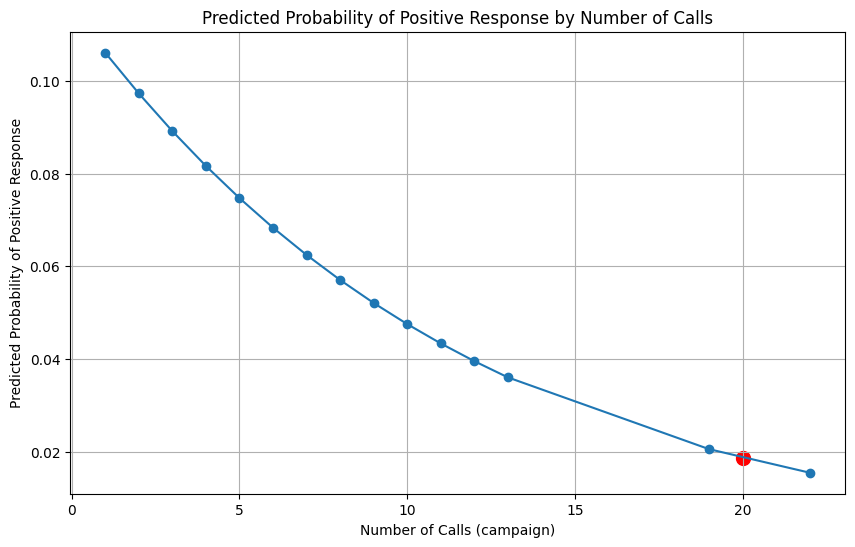

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Prepare features/target
target_map = {'yes': 1, 'no': 0}
y_train = train_df['y'].map(target_map)
y_eval = eval_df['y'].map(target_map)
X_train = train_df[['campaign']]
X_eval = eval_df[['campaign']]
# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
# Predict probabilities for evaluation set
probs = model.predict_proba(X_eval)[:, 1]
# Aggregate probabilities by number of calls
eval_df = eval_df.copy()
eval_df['predicted_prob'] = probs
call_stats = eval_df.groupby('campaign')['predicted_prob'].mean().reset_index()

# Ask the user for a call number to evaluate
call_number = int(input("Enter the number of calls to evaluate: "))
predicted_prob = model.predict_proba([[call_number]])[0, 1]
print(f'Predicted probability of positive response after {call_number} calls: {predicted_prob:.4f}')

# Plot predicted value for the input call number
plt.figure(figsize=(10, 6))
plt.plot(call_stats['campaign'], call_stats['predicted_prob'], marker='o', label='Predicted Probability')
plt.scatter([call_number], [predicted_prob], color='red', s=100, label='Input Call Number Prediction')
plt.title('Predicted Probability of Positive Response by Number of Calls')
plt.xlabel('Number of Calls (campaign)')
plt.ylabel('Predicted Probability of Positive Response')
plt.grid()



Loading data from: Data\bank-additional-full.csv
Data loaded: 41188 total records
Train set: 32950 records, Eval set: 8238 records

QUESTION 1: Average number of calls for clients who said 'yes'

Number of clients who said 'yes': 4,640
Average number of calls for 'yes' clients: 2.05 calls
Median number of calls for 'yes' clients: 2.0 calls
Min calls: 1, Max calls: 23

QUESTION 2: When does calling again result in a negative outcome?

Peak conversion rate: 0.1304 (13.04%) at 1 calls

Conversion rate drops below 50% of peak at 7.0 calls
  Rate: 0.0604 (6.04%)

Recommendation: Stop calling after 16.0 calls
  (Conversion rate drops below 1% at this point)
Predicted probability of positive response after 3 calls: 0.1031


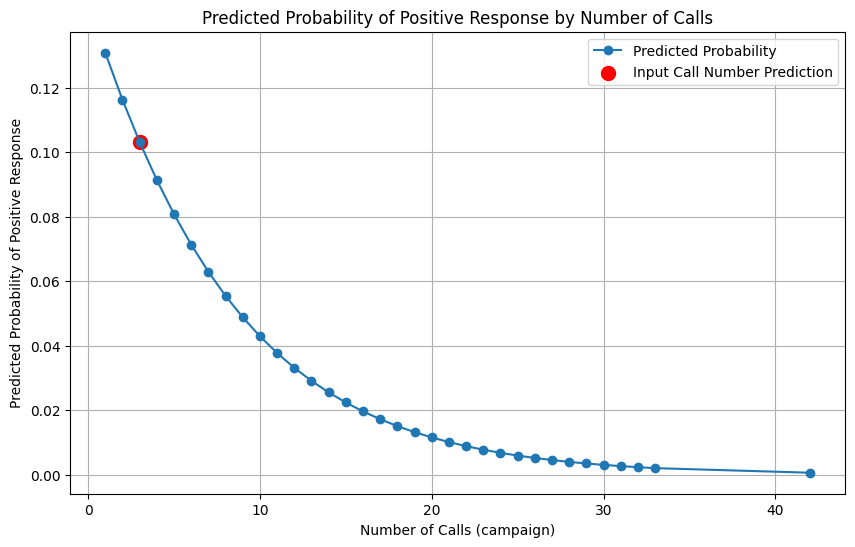

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.model_selection import train_test_split

# ============================================================================
# DATA LOADING
# ============================================================================
def load_data():
    """Try to load the bank marketing dataset from various possible paths."""
    possible_paths = [
        Path("ITEC3040-Final-Project/Data/bank-additional-full.csv"),
        Path("Data/bank-additional-full.csv"),
        Path("bank-additional-full.csv"),
        Path("ITEC3040-Final-Project/Data/bank-full.csv"),
        Path("Data/bank-full.csv"),
        Path("bank-full.csv"),
    ]

    for path in possible_paths:
        if path.exists():
            print(f"Loading data from: {path}")
            df = pd.read_csv(path, sep=';')
            return df

    # If train_df and eval_df are already defined, use them
    try:
        if 'train_df' in globals() and 'eval_df' in globals():
            print("Using existing train_df and eval_df")
            return pd.concat([train_df, eval_df], ignore_index=True)
    except:
        pass

    raise FileNotFoundError(
        "Could not find the data file. Please ensure the bank dataset CSV file exists."
    )

# Load and split data
try:
    df = load_data()
    # Split into train and eval sets (80/20 split)
    train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)
    print(f"Data loaded: {len(df)} total records")
    print(f"Train set: {len(train_df)} records, Eval set: {len(eval_df)} records")
except FileNotFoundError as e:
    print(e)
    print("\nAttempting to use train_df and eval_df if available...")
    # If train_df and eval_df are already loaded, use them
    if 'train_df' not in globals() or 'eval_df' not in globals():
        raise ValueError("Please load train_df and eval_df before running this script")

# ============================================================================
# QUESTION 1: Average number of calls for clients who said "yes"
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: Average number of calls for clients who said 'yes'")
print("="*70)

# Use full dataset for this analysis
full_df = pd.concat([train_df, eval_df], ignore_index=True)
yes_clients = full_df[full_df['y'] == 'yes'].copy()

if len(yes_clients) > 0:
    avg_calls_yes = yes_clients['campaign'].mean()
    median_calls_yes = yes_clients['campaign'].median()

    print(f"\nNumber of clients who said 'yes': {len(yes_clients):,}")
    print(f"Average number of calls for 'yes' clients: {avg_calls_yes:.2f} calls")
    print(f"Median number of calls for 'yes' clients: {median_calls_yes:.1f} calls")
    print(f"Min calls: {yes_clients['campaign'].min()}, Max calls: {yes_clients['campaign'].max()}")
else:
    print("\nNo clients said 'yes' in the dataset!")
    avg_calls_yes = None

# ============================================================================
# QUESTION 2: When does calling again result in a negative outcome?
# ============================================================================
print("\n" + "="*70)
print("QUESTION 2: When does calling again result in a negative outcome?")
print("="*70)

# Calculate actual conversion rate by number of calls
conversion_by_calls = full_df.groupby('campaign').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()]
}).reset_index()
conversion_by_calls.columns = ['calls', 'total_clients', 'yes_count', 'conversion_rate']

# Filter to calls with sufficient samples (at least 10 clients)
conversion_by_calls_filtered = conversion_by_calls[conversion_by_calls['total_clients'] >= 10].copy()

if len(conversion_by_calls_filtered) > 1:
    # Find peak conversion rate
    peak_idx = conversion_by_calls_filtered['conversion_rate'].idxmax()
    peak_calls = conversion_by_calls_filtered.loc[peak_idx, 'calls']
    peak_rate = conversion_by_calls_filtered.loc[peak_idx, 'conversion_rate']

    print(f"\nPeak conversion rate: {peak_rate:.4f} ({peak_rate*100:.2f}%) at {peak_calls} calls")

    # Find where conversion rate drops significantly (below 50% of peak)
    threshold_rate = peak_rate * 0.5
    negative_trend = conversion_by_calls_filtered[
        (conversion_by_calls_filtered['calls'] > peak_calls) &
        (conversion_by_calls_filtered['conversion_rate'] < threshold_rate)
    ]

    if len(negative_trend) > 0:
        first_negative = negative_trend.iloc[0]
        print(f"\nConversion rate drops below 50% of peak at {first_negative['calls']} calls")
        print(f"  Rate: {first_negative['conversion_rate']:.4f} ({first_negative['conversion_rate']*100:.2f}%)")

    # Find where conversion rate becomes very low (< 1%)
    very_low = conversion_by_calls_filtered[conversion_by_calls_filtered['conversion_rate'] < 0.01]
    if len(very_low) > 0:
        print(f"\nRecommendation: Stop calling after {very_low.iloc[0]['calls']} calls")
        print(f"  (Conversion rate drops below 1% at this point)")

# ============================================================================
# LOGISTIC REGRESSION MODEL (Original functionality)
# ============================================================================
# Prepare features/target
target_map = {'yes': 1, 'no': 0}
y_train = train_df['y'].map(target_map)
y_eval = eval_df['y'].map(target_map)
X_train = train_df[['campaign']]
X_eval = eval_df[['campaign']]

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for evaluation set
probs = model.predict_proba(X_eval)[:, 1]
eval_df_copy = eval_df.copy()
eval_df_copy['predicted_prob'] = probs
call_stats = eval_df_copy.groupby('campaign')['predicted_prob'].mean().reset_index()

# Ask the user for a call number to evaluate
call_number = int(input("\nEnter the number of calls to evaluate: "))
predicted_prob = model.predict_proba([[call_number]])[0, 1]
print(f'Predicted probability of positive response after {call_number} calls: {predicted_prob:.4f}')

# Plot predicted value for the input call number
plt.figure(figsize=(10, 6))
plt.plot(call_stats['campaign'], call_stats['predicted_prob'], marker='o', label='Predicted Probability')
plt.scatter([call_number], [predicted_prob], color='red', s=100, label='Input Call Number Prediction')
plt.title('Predicted Probability of Positive Response by Number of Calls')
plt.xlabel('Number of Calls (campaign)')
plt.ylabel('Predicted Probability of Positive Response')
plt.grid()
plt.legend()
plt.show()


STEP 1: Finding Peak Calling Frequency

Peak conversion rate: 0.1304 (13.04%) at 1 calls
Using 1 calls as the threshold for classification

STEP 2: Classifying Clients (Before Peak vs After Peak)

Client Distribution:
  Before Peak (≤1 calls): 17,642 clients (42.8%)
  After Peak (>1 calls): 23,546 clients (57.2%)

STEP 3: Subscription Rates by Peak Category

Subscription Analysis:
   category  total  yes_count  no_count  conversion_rate
 After Peak  23546       2340     21206         0.099380
Before Peak  17642       2300     15342         0.130371

Detailed Breakdown:

Before Peak:
  Yes (Subscribe): 2,300 (13.04%)
  No (Not Subscribe): 15,342 (86.96%)
  Total: 17,642

After Peak:
  Yes (Subscribe): 2,340 (9.94%)
  No (Not Subscribe): 21,206 (90.06%)
  Total: 23,546

----------------------------------------------------------------------
Conversion Rate Comparison:
  Before Peak: 0.1304 (13.04%)
  After Peak: 0.0994 (9.94%)
  Difference: 0.0310 (3.10 percentage points)
  → Before Peak 

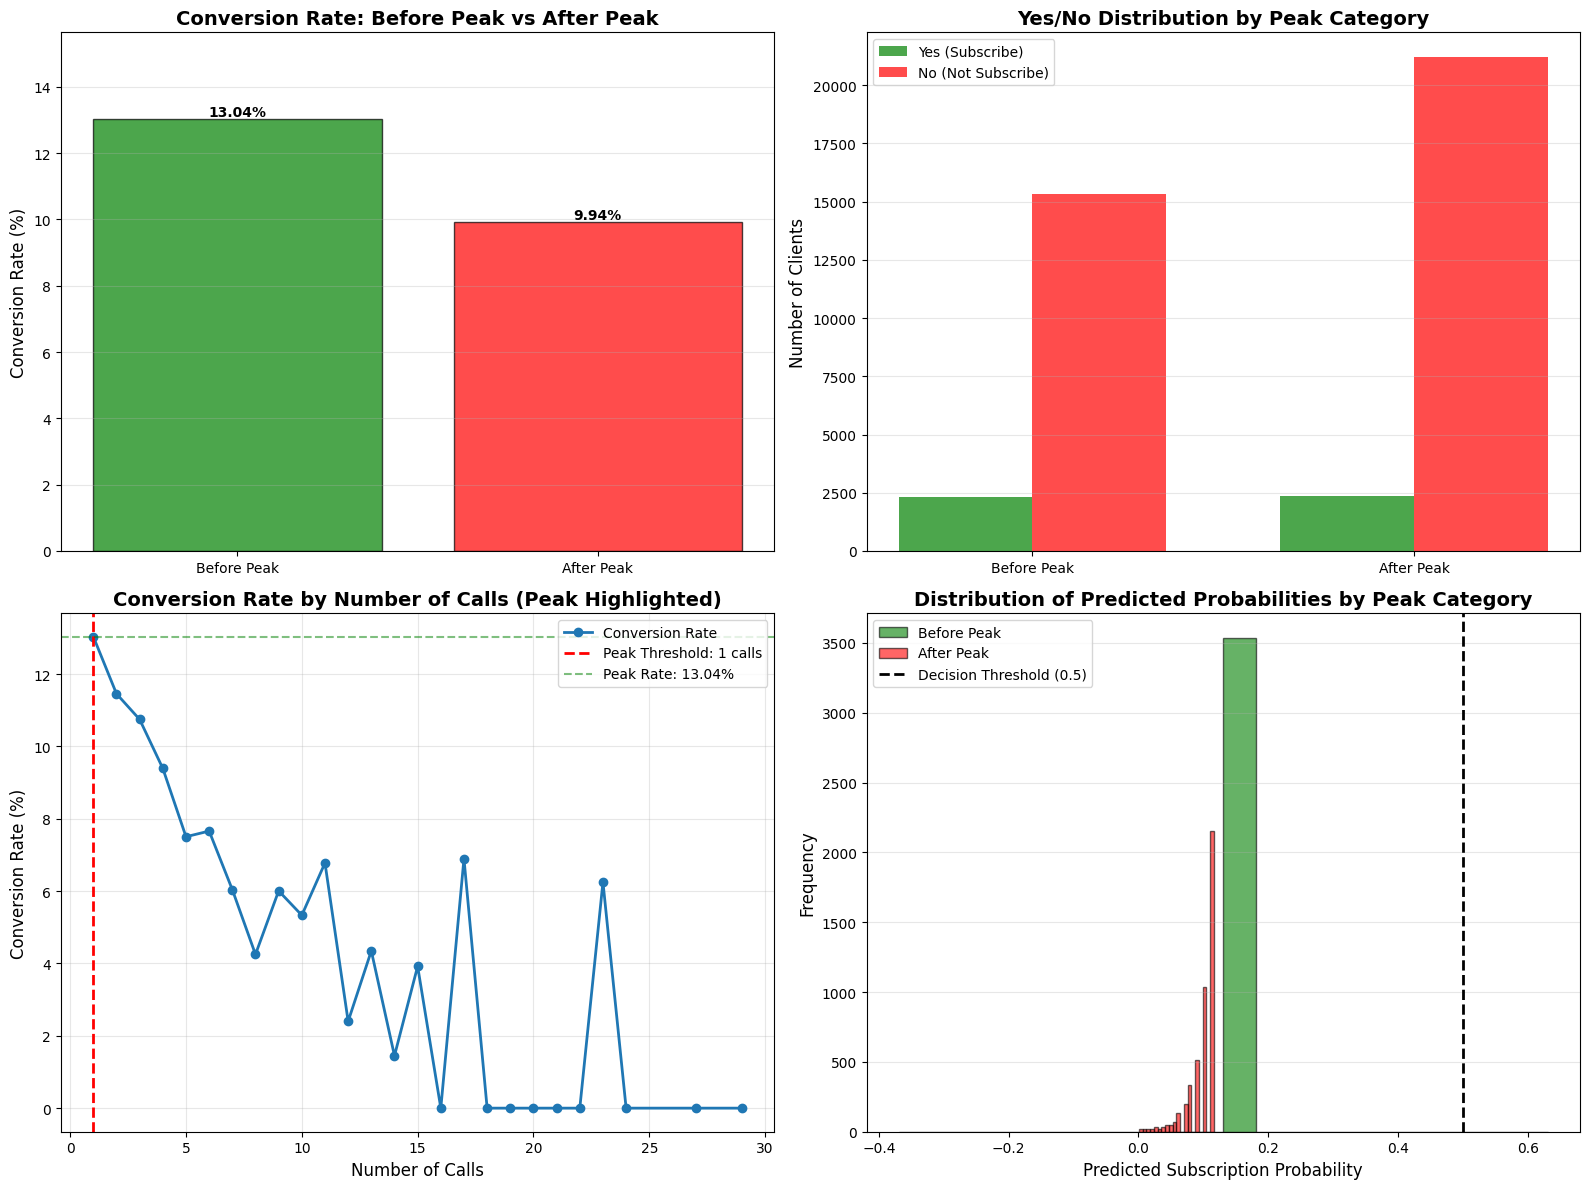


SUMMARY AND RECOMMENDATIONS

1. Peak Calling Frequency: 1 calls
2. Before Peak clients (≤1 calls) have 13.04% conversion rate
3. After Peak clients (>1 calls) have 9.94% conversion rate
4. Recommendation: Focus efforts on clients with ≤1 calls
   → Before Peak clients are 23.8% more likely to subscribe

5. Best Model: Combined (Peak + Calls) with accuracy of 0.8865

----------------------------------------------------------------------

Client Classification: After Peak
Predicted probability of subscription: 0.0914 (9.14%)
Predicted subscription likelihood: Unlikely


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ============================================================================
# STEP 1: FIND PEAK CALLING FREQUENCY
# ============================================================================
print("="*70)
print("STEP 1: Finding Peak Calling Frequency")
print("="*70)

# Combine train and eval to find peak
full_df = pd.concat([train_df, eval_df], ignore_index=True)

# Calculate actual conversion rate by number of calls
conversion_by_calls = full_df.groupby('campaign').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()]
}).reset_index()
conversion_by_calls.columns = ['calls', 'total_clients', 'yes_count', 'conversion_rate']

# Filter to calls with sufficient samples (at least 10 clients)
conversion_by_calls_filtered = conversion_by_calls[conversion_by_calls['total_clients'] >= 10].copy()

if len(conversion_by_calls_filtered) > 1:
    # Find peak conversion rate
    peak_idx = conversion_by_calls_filtered['conversion_rate'].idxmax()
    peak_calls = int(conversion_by_calls_filtered.loc[peak_idx, 'calls'])
    peak_rate = conversion_by_calls_filtered.loc[peak_idx, 'conversion_rate']

    print(f"\nPeak conversion rate: {peak_rate:.4f} ({peak_rate*100:.2f}%) at {peak_calls} calls")
    print(f"Using {peak_calls} calls as the threshold for classification")
else:
    # Fallback: use median if we can't find a clear peak
    peak_calls = int(full_df['campaign'].median())
    print(f"\nUsing median calls ({peak_calls}) as threshold")

# ============================================================================
# STEP 2: CLASSIFY CLIENTS AS BEFORE/AFTER PEAK
# ============================================================================
print("\n" + "="*70)
print("STEP 2: Classifying Clients (Before Peak vs After Peak)")
print("="*70)

# Add classification to full dataset
full_df = full_df.copy()
full_df['before_peak'] = (full_df['campaign'] <= peak_calls).astype(int)
full_df['peak_category'] = full_df['before_peak'].map({1: 'Before Peak', 0: 'After Peak'})

# Split back into train and eval with new classification
train_df_classified = full_df.iloc[:len(train_df)].copy()
eval_df_classified = full_df.iloc[len(train_df):].copy()

# Statistics
before_peak_count = (full_df['campaign'] <= peak_calls).sum()
after_peak_count = (full_df['campaign'] > peak_calls).sum()

print(f"\nClient Distribution:")
print(f"  Before Peak (≤{peak_calls} calls): {before_peak_count:,} clients ({before_peak_count/len(full_df)*100:.1f}%)")
print(f"  After Peak (>{peak_calls} calls): {after_peak_count:,} clients ({after_peak_count/len(full_df)*100:.1f}%)")

# ============================================================================
# STEP 3: COMPARE SUBSCRIPTION RATES (YES/NO) BY PEAK CATEGORY
# ============================================================================
print("\n" + "="*70)
print("STEP 3: Subscription Rates by Peak Category")
print("="*70)

# Calculate conversion rates
subscription_analysis = full_df.groupby('peak_category').agg({
    'y': ['count',
          lambda x: (x == 'yes').sum(),
          lambda x: (x == 'no').sum(),
          lambda x: (x == 'yes').mean()]
}).reset_index()
subscription_analysis.columns = ['category', 'total', 'yes_count', 'no_count', 'conversion_rate']

print("\nSubscription Analysis:")
print(subscription_analysis.to_string(index=False))

# Detailed breakdown
print("\nDetailed Breakdown:")
for category in ['Before Peak', 'After Peak']:
    subset = full_df[full_df['peak_category'] == category]
    yes_count = (subset['y'] == 'yes').sum()
    no_count = (subset['y'] == 'no').sum()
    total = len(subset)
    yes_pct = yes_count / total * 100
    no_pct = no_count / total * 100

    print(f"\n{category}:")
    print(f"  Yes (Subscribe): {yes_count:,} ({yes_pct:.2f}%)")
    print(f"  No (Not Subscribe): {no_count:,} ({no_pct:.2f}%)")
    print(f"  Total: {total:,}")

# Statistical comparison
before_peak_rate = subscription_analysis[subscription_analysis['category'] == 'Before Peak']['conversion_rate'].values[0]
after_peak_rate = subscription_analysis[subscription_analysis['category'] == 'After Peak']['conversion_rate'].values[0]
rate_difference = before_peak_rate - after_peak_rate

print(f"\n" + "-"*70)
print(f"Conversion Rate Comparison:")
print(f"  Before Peak: {before_peak_rate:.4f} ({before_peak_rate*100:.2f}%)")
print(f"  After Peak: {after_peak_rate:.4f} ({after_peak_rate*100:.2f}%)")
print(f"  Difference: {rate_difference:.4f} ({rate_difference*100:.2f} percentage points)")
if rate_difference > 0:
    print(f"  → Before Peak clients are {rate_difference/before_peak_rate*100:.1f}% MORE likely to subscribe")
else:
    print(f"  → After Peak clients are {abs(rate_difference)/after_peak_rate*100:.1f}% MORE likely to subscribe")

# ============================================================================
# STEP 4: BUILD CLASSIFICATION MODEL
# ============================================================================
print("\n" + "="*70)
print("STEP 4: Building Classification Model")
print("="*70)

# Prepare features/target for classification model
target_map = {'yes': 1, 'no': 0}
y_train = train_df_classified['y'].map(target_map)
y_eval = eval_df_classified['y'].map(target_map)

# Model 1: Using only before_peak classification
X_train_binary = train_df_classified[['before_peak']]
X_eval_binary = eval_df_classified[['before_peak']]

model_binary = LogisticRegression()
model_binary.fit(X_train_binary, y_train)

# Model 2: Using number of calls (original)
X_train_calls = train_df_classified[['campaign']]
X_eval_calls = eval_df_classified[['campaign']]

model_calls = LogisticRegression()
model_calls.fit(X_train_calls, y_train)

# Model 3: Using both before_peak and campaign
X_train_combined = train_df_classified[['before_peak', 'campaign']]
X_eval_combined = eval_df_classified[['before_peak', 'campaign']]

model_combined = LogisticRegression()
model_combined.fit(X_train_combined, y_train)

# Evaluate models
print("\nModel Performance Comparison:")
print("-"*70)

models = {
    'Before/After Peak Only': (model_binary, X_eval_binary),
    'Number of Calls Only': (model_calls, X_eval_calls),
    'Combined (Peak + Calls)': (model_combined, X_eval_combined)
}

for name, (model, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    accuracy = accuracy_score(y_eval, y_pred)
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Classification Report:")
    report = classification_report(y_eval, y_pred, target_names=['No', 'Yes'], output_dict=True)
    print(f"    Precision (Yes): {report['Yes']['precision']:.4f}")
    print(f"    Recall (Yes): {report['Yes']['recall']:.4f}")
    print(f"    F1-Score (Yes): {report['Yes']['f1-score']:.4f}")

# ============================================================================
# STEP 5: PREDICT SUBSCRIPTION LIKELIHOOD
# ============================================================================
print("\n" + "="*70)
print("STEP 5: Predicting Subscription Likelihood")
print("="*70)

# Predict probabilities for evaluation set using combined model
probs_combined = model_combined.predict_proba(X_eval_combined)[:, 1]
eval_df_classified = eval_df_classified.copy()
eval_df_classified['predicted_prob'] = probs_combined
eval_df_classified['predicted_class'] = (probs_combined >= 0.5).astype(int)
eval_df_classified['predicted_label'] = eval_df_classified['predicted_class'].map({1: 'Likely', 0: 'Unlikely'})

# Analyze predictions by peak category
prediction_analysis = eval_df_classified.groupby(['peak_category', 'predicted_label']).size().unstack(fill_value=0)
print("\nPredicted Subscription Likelihood by Peak Category:")
print(prediction_analysis)

# Actual vs Predicted by peak category
actual_pred_by_peak = pd.crosstab(
    eval_df_classified['peak_category'],
    [eval_df_classified['y'], eval_df_classified['predicted_label']],
    margins=True
)
print("\nActual Response vs Predicted Likelihood by Peak Category:")
print(actual_pred_by_peak)

# ============================================================================
# VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Conversion rate by peak category
ax1 = axes[0, 0]
categories = ['Before Peak', 'After Peak']
conversion_rates = [before_peak_rate * 100, after_peak_rate * 100]
colors = ['green', 'red']
bars = ax1.bar(categories, conversion_rates, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Conversion Rate (%)', fontsize=12)
ax1.set_title('Conversion Rate: Before Peak vs After Peak', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(conversion_rates) * 1.2)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, rate in zip(bars, conversion_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Distribution of yes/no by peak category
ax2 = axes[0, 1]
before_yes = (full_df[(full_df['peak_category'] == 'Before Peak') & (full_df['y'] == 'yes')]).shape[0]
before_no = (full_df[(full_df['peak_category'] == 'Before Peak') & (full_df['y'] == 'no')]).shape[0]
after_yes = (full_df[(full_df['peak_category'] == 'After Peak') & (full_df['y'] == 'yes')]).shape[0]
after_no = (full_df[(full_df['peak_category'] == 'After Peak') & (full_df['y'] == 'no')]).shape[0]

x = np.arange(2)
width = 0.35
ax2.bar(x - width/2, [before_yes, after_yes], width, label='Yes (Subscribe)', color='green', alpha=0.7)
ax2.bar(x + width/2, [before_no, after_no], width, label='No (Not Subscribe)', color='red', alpha=0.7)
ax2.set_ylabel('Number of Clients', fontsize=12)
ax2.set_title('Yes/No Distribution by Peak Category', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Conversion rate by number of calls (with peak line)
ax3 = axes[1, 0]
ax3.plot(conversion_by_calls_filtered['calls'],
         conversion_by_calls_filtered['conversion_rate'] * 100,
         marker='o', linewidth=2, markersize=6, label='Conversion Rate')
ax3.axvline(x=peak_calls, color='red', linestyle='--', linewidth=2,
           label=f'Peak Threshold: {peak_calls} calls')
ax3.axhline(y=peak_rate * 100, color='green', linestyle='--', alpha=0.5,
           label=f'Peak Rate: {peak_rate*100:.2f}%')
ax3.set_xlabel('Number of Calls', fontsize=12)
ax3.set_ylabel('Conversion Rate (%)', fontsize=12)
ax3.set_title('Conversion Rate by Number of Calls (Peak Highlighted)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Predicted probabilities by peak category
ax4 = axes[1, 1]
before_probs = eval_df_classified[eval_df_classified['peak_category'] == 'Before Peak']['predicted_prob']
after_probs = eval_df_classified[eval_df_classified['peak_category'] == 'After Peak']['predicted_prob']

ax4.hist(before_probs, bins=20, alpha=0.6, label='Before Peak', color='green', edgecolor='black')
ax4.hist(after_probs, bins=20, alpha=0.6, label='After Peak', color='red', edgecolor='black')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
ax4.set_xlabel('Predicted Subscription Probability', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Predicted Probabilities by Peak Category', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "="*70)
print("SUMMARY AND RECOMMENDATIONS")
print("="*70)
print(f"\n1. Peak Calling Frequency: {peak_calls} calls")
print(f"2. Before Peak clients (≤{peak_calls} calls) have {before_peak_rate*100:.2f}% conversion rate")
print(f"3. After Peak clients (>{peak_calls} calls) have {after_peak_rate*100:.2f}% conversion rate")
print(f"4. Recommendation: Focus efforts on clients with ≤{peak_calls} calls")
if rate_difference > 0:
    print(f"   → Before Peak clients are {rate_difference/before_peak_rate*100:.1f}% more likely to subscribe")
print(f"\n5. Best Model: Combined (Peak + Calls) with accuracy of {accuracy_score(y_eval, model_combined.predict(X_eval_combined)):.4f}")
print("="*70)

# Interactive prediction
print("\n" + "-"*70)
call_number = int(input("Enter the number of calls to evaluate: "))
is_before_peak = 1 if call_number <= peak_calls else 0
predicted_prob = model_combined.predict_proba([[is_before_peak, call_number]])[0, 1]
predicted_class = 'Likely' if predicted_prob >= 0.5 else 'Unlikely'
category = 'Before Peak' if is_before_peak else 'After Peak'

print(f'\nClient Classification: {category}')
print(f'Predicted probability of subscription: {predicted_prob:.4f} ({predicted_prob*100:.2f}%)')
print(f'Predicted subscription likelihood: {predicted_class}')


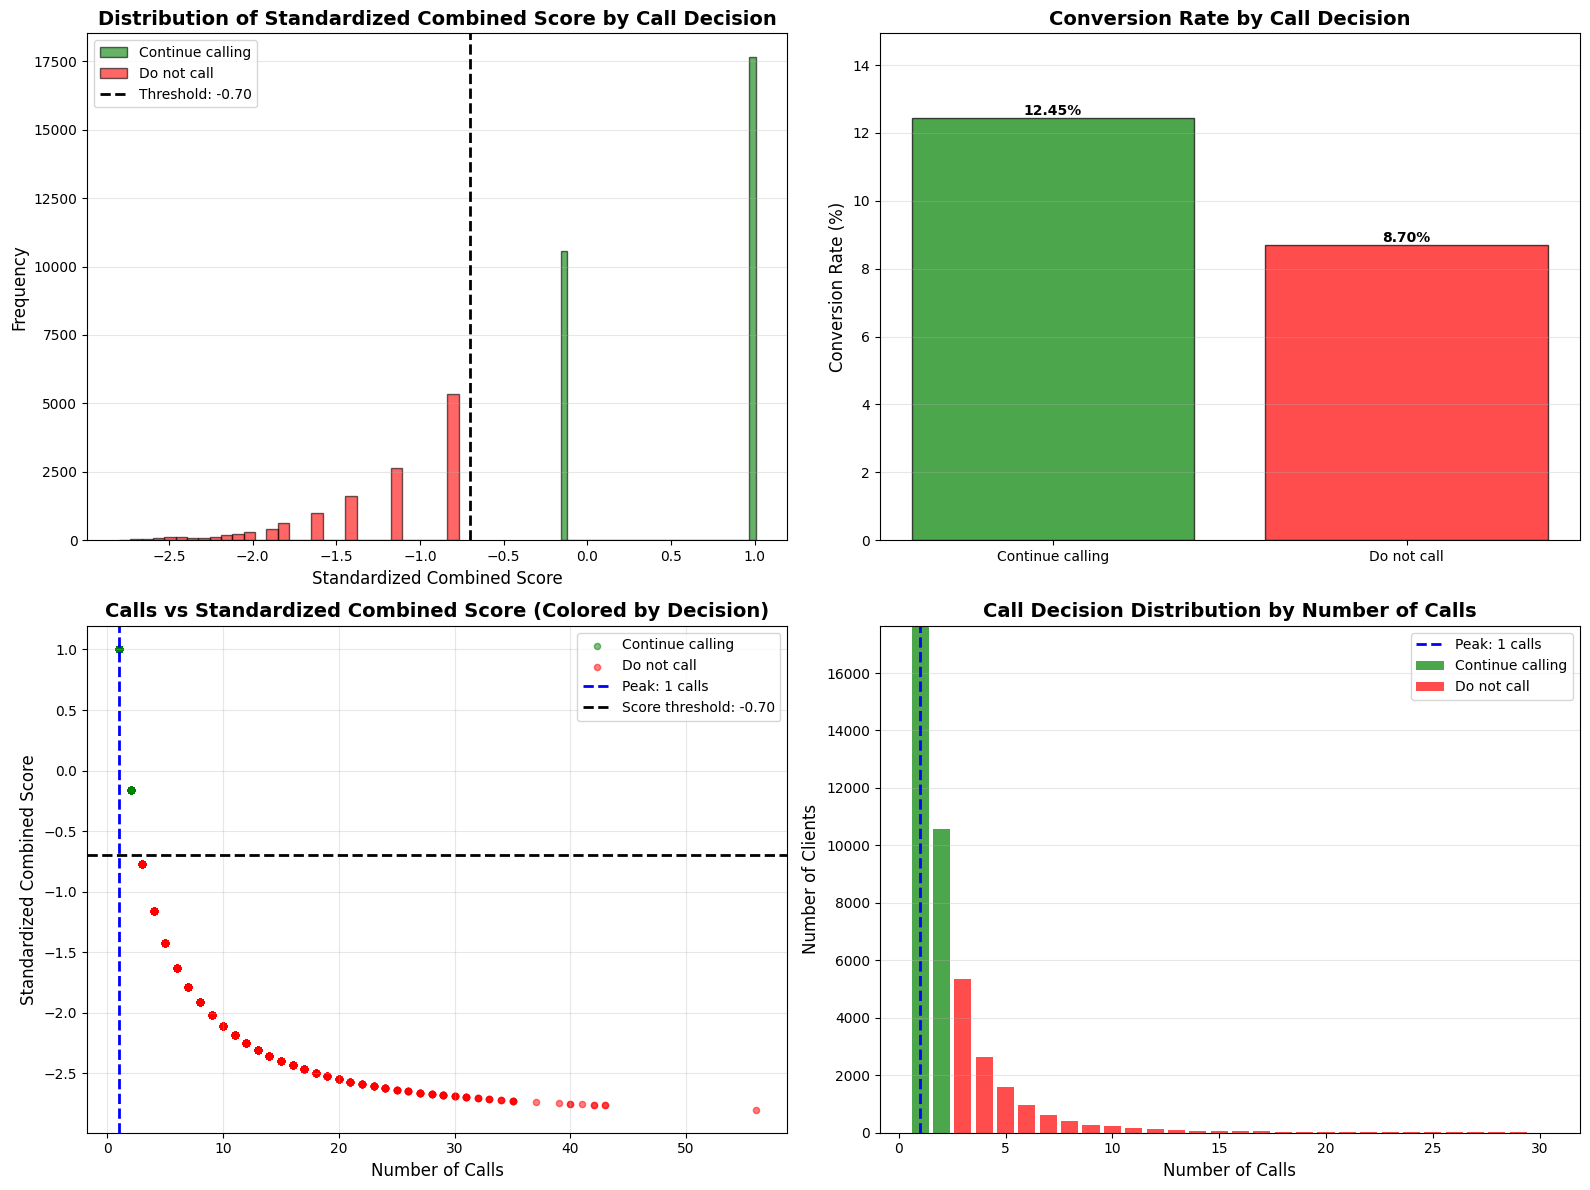


SUMMARY

Peak Conversion Rate: 13.04% at 1 calls
Inputted Calls: 3 calls
Conversion Rate at 3 calls: 10.75%

Difference: 17.6% reduction from peak

Recommendation: Calling is significantly less effective. Stop calling.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================================
# STEP 1: FIND PEAK CALLING FREQUENCY
# ============================================================================
# Combine train and eval to analyze full dataset
full_df = pd.concat([train_df, eval_df], ignore_index=True)

# Calculate actual conversion rate by number of calls
conversion_by_calls = full_df.groupby('campaign').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()]
}).reset_index()
conversion_by_calls.columns = ['calls', 'total_clients', 'yes_count', 'conversion_rate']

# Filter to calls with sufficient samples (at least 10 clients)
conversion_by_calls_filtered = conversion_by_calls[conversion_by_calls['total_clients'] >= 10].copy()

if len(conversion_by_calls_filtered) > 1:
    # Find peak conversion rate
    peak_idx = conversion_by_calls_filtered['conversion_rate'].idxmax()
    peak_calls = int(conversion_by_calls_filtered.loc[peak_idx, 'calls'])
    peak_rate = conversion_by_calls_filtered.loc[peak_idx, 'conversion_rate']

    # Find where conversion rate drops below 1% (stopping point)
    very_low = conversion_by_calls_filtered[conversion_by_calls_filtered['conversion_rate'] < 0.01]
    if len(very_low) > 0:
        stop_calls = int(very_low.iloc[0]['calls'])
    else:
        stop_calls = min(peak_calls * 2, int(conversion_by_calls_filtered['calls'].max()))
else:
    peak_calls = int(full_df['campaign'].median())
    stop_calls = int(full_df['campaign'].quantile(0.95))
    peak_rate = 0.0

# ============================================================================
# STEP 2: TRAIN MODEL AND CALCULATE SUBSCRIPTION LIKELIHOOD
# ============================================================================
# Prepare features/target
target_map = {'yes': 1, 'no': 0}
y_train = train_df['y'].map(target_map)
y_eval = eval_df['y'].map(target_map)
X_train = train_df[['campaign']]
X_eval = eval_df[['campaign']]

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for all data
full_df = full_df.copy()
full_probs = model.predict_proba(full_df[['campaign']])[:, 1]
full_df['subscription_likelihood'] = full_probs

# Predict for train and eval separately
train_probs = model.predict_proba(X_train)[:, 1]
eval_probs = model.predict_proba(X_eval)[:, 1]

train_df_classified = train_df.copy()
eval_df_classified = eval_df.copy()
train_df_classified['subscription_likelihood'] = train_probs
eval_df_classified['subscription_likelihood'] = eval_probs

# ============================================================================
# STEP 3: STANDARDIZE SUBSCRIPTION LIKELIHOOD
# ============================================================================
# Create an inverted call score where 1 call = highest, more calls = lower
max_calls = full_df['campaign'].max()
full_df['inverted_call_score'] = 1.0 / (full_df['campaign'] + 1)
full_df['inverted_call_score'] = full_df['inverted_call_score'] / full_df['inverted_call_score'].max()

train_df_classified['inverted_call_score'] = 1.0 / (train_df_classified['campaign'] + 1)
train_df_classified['inverted_call_score'] = train_df_classified['inverted_call_score'] / train_df_classified['inverted_call_score'].max()

eval_df_classified['inverted_call_score'] = 1.0 / (eval_df_classified['campaign'] + 1)
eval_df_classified['inverted_call_score'] = eval_df_classified['inverted_call_score'] / eval_df_classified['inverted_call_score'].max()

# Create combined score: 40% call score, 60% subscription likelihood
full_df['combined_score'] = 0.4 * full_df['inverted_call_score'] + 0.6 * full_df['subscription_likelihood']
train_df_classified['combined_score'] = 0.4 * train_df_classified['inverted_call_score'] + 0.6 * train_df_classified['subscription_likelihood']
eval_df_classified['combined_score'] = 0.4 * eval_df_classified['inverted_call_score'] + 0.6 * eval_df_classified['subscription_likelihood']

# Standardize the combined score
scaler = StandardScaler()
full_df['standardized_score'] = scaler.fit_transform(full_df[['combined_score']])
train_df_classified['standardized_score'] = scaler.transform(train_df_classified[['combined_score']])
eval_df_classified['standardized_score'] = scaler.transform(eval_df_classified[['combined_score']])

# Keep standardized likelihood for reference
likelihood_scaler = StandardScaler()
full_df['likelihood_standardized'] = likelihood_scaler.fit_transform(full_df[['subscription_likelihood']])
train_df_classified['likelihood_standardized'] = likelihood_scaler.transform(train_df_classified[['subscription_likelihood']])
eval_df_classified['likelihood_standardized'] = likelihood_scaler.transform(eval_df_classified[['subscription_likelihood']])

# ============================================================================
# STEP 4: DETERMINE CLASSIFICATION THRESHOLD
# ============================================================================
def find_optimal_threshold_std(y_true, y_std_scores):
    """Find optimal threshold using Youden's J statistic on standardized scores."""
    thresholds = np.arange(y_std_scores.min(), y_std_scores.max(), 0.1)
    best_threshold = 0.0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_std_scores >= threshold).astype(int)
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))

        if (tp + fn) > 0 and (tn + fp) > 0:
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            youden_j = sensitivity + specificity - 1

            if youden_j > best_score:
                best_score = youden_j
                best_threshold = threshold

    return best_threshold

# Use actual conversion (yes/no) as the target for threshold optimization
y_full = (full_df['y'] == 'yes').astype(int)
optimal_std_threshold = find_optimal_threshold_std(y_full, full_df['standardized_score'])

# Find conversion rates by call count
conversion_by_calls_dict = dict(zip(conversion_by_calls['calls'], conversion_by_calls['conversion_rate']))
min_conversion_threshold = 0.01  # 1% minimum conversion rate to continue

# ============================================================================
# STEP 5: CLASSIFY CLIENTS INTO "CONTINUE CALLING" OR "DO NOT CALL"
# ============================================================================

def classify_client(calls, likelihood, standardized_score, inverted_call_score):
    """
    Classify client as "Continue calling" or "Do not call"

    Uses standardized combined score that accounts for:
    - Inverted call score (fewer calls = higher score)
    - Subscription likelihood (higher probability = higher score)

    Continue calling if standardized combined score > threshold
    OR if calls are low and conversion rate is still reasonable
    """
    # Primary criterion: standardized combined score
    score_above_threshold = standardized_score > optimal_std_threshold

    # Secondary criterion: if calls are low and conversion rate is still reasonable
    calls_low = calls <= peak_calls
    conversion_rate = conversion_by_calls_dict.get(calls, 0.0)
    conversion_still_good = conversion_rate > min_conversion_threshold

    # Continue if primary criterion OR (low calls AND good conversion)
    continue_calling = score_above_threshold or (calls_low and conversion_still_good)

    return "Continue calling" if continue_calling else "Do not call"

# Classify all clients
full_df['call_decision'] = full_df.apply(
    lambda row: classify_client(row['campaign'], row['subscription_likelihood'],
                                row['standardized_score'], row['inverted_call_score']),
    axis=1
)

train_df_classified['call_decision'] = train_df_classified.apply(
    lambda row: classify_client(row['campaign'], row['subscription_likelihood'],
                               row['standardized_score'], row['inverted_call_score']),
    axis=1
)

eval_df_classified['call_decision'] = eval_df_classified.apply(
    lambda row: classify_client(row['campaign'], row['subscription_likelihood'],
                               row['standardized_score'], row['inverted_call_score']),
    axis=1
)

# Analyze conversion rates by decision
decision_analysis = full_df.groupby('call_decision').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()],
    'subscription_likelihood': 'mean',
    'standardized_score': 'mean',
    'inverted_call_score': 'mean',
    'campaign': 'mean'
}).reset_index()
decision_analysis.columns = ['decision', 'total', 'yes_count', 'conversion_rate', 'avg_likelihood', 'avg_std_score', 'avg_inv_call_score', 'avg_calls']

# ============================================================================
# STEP 6: BUILD PREDICTIVE MODEL FOR CALL DECISION
# ============================================================================
# Create binary target for call decision (1 = Continue, 0 = Stop)
train_df_classified['should_call'] = (train_df_classified['call_decision'] == 'Continue calling').astype(int)
eval_df_classified['should_call'] = (eval_df_classified['call_decision'] == 'Continue calling').astype(int)

# Features: campaign, subscription_likelihood, standardized_score, inverted_call_score
X_train_decision = train_df_classified[['campaign', 'subscription_likelihood', 'standardized_score', 'inverted_call_score']]
X_eval_decision = eval_df_classified[['campaign', 'subscription_likelihood', 'standardized_score', 'inverted_call_score']]
y_train_decision = train_df_classified['should_call']
y_eval_decision = eval_df_classified['should_call']

# Train decision model
decision_model = LogisticRegression()
decision_model.fit(X_train_decision, y_train_decision)

# ============================================================================
# VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribution of standardized combined score by decision
ax1 = axes[0, 0]
continue_std = full_df[full_df['call_decision'] == 'Continue calling']['standardized_score']
stop_std = full_df[full_df['call_decision'] == 'Do not call']['standardized_score']

ax1.hist(continue_std, bins=30, alpha=0.6, label='Continue calling', color='green', edgecolor='black')
ax1.hist(stop_std, bins=30, alpha=0.6, label='Do not call', color='red', edgecolor='black')
ax1.axvline(x=optimal_std_threshold, color='black', linestyle='--', linewidth=2,
           label=f'Threshold: {optimal_std_threshold:.2f}')
ax1.set_xlabel('Standardized Combined Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Standardized Combined Score by Call Decision', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Conversion rate by call decision
ax2 = axes[0, 1]
continue_rate = decision_analysis[decision_analysis['decision'] == 'Continue calling']['conversion_rate'].values[0] * 100
stop_rate = decision_analysis[decision_analysis['decision'] == 'Do not call']['conversion_rate'].values[0] * 100

categories = ['Continue calling', 'Do not call']
rates = [continue_rate, stop_rate]
colors = ['green', 'red']
bars = ax2.bar(categories, rates, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Conversion Rate (%)', fontsize=12)
ax2.set_title('Conversion Rate by Call Decision', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(rates) * 1.2)
ax2.grid(True, alpha=0.3, axis='y')

for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Number of calls vs standardized combined score (colored by decision)
ax3 = axes[1, 0]
continue_df = full_df[full_df['call_decision'] == 'Continue calling']
stop_df = full_df[full_df['call_decision'] == 'Do not call']

ax3.scatter(continue_df['campaign'], continue_df['standardized_score'],
           alpha=0.5, s=20, label='Continue calling', color='green')
ax3.scatter(stop_df['campaign'], stop_df['standardized_score'],
           alpha=0.5, s=20, label='Do not call', color='red')
ax3.axvline(x=peak_calls, color='blue', linestyle='--', linewidth=2,
           label=f'Peak: {peak_calls} calls')
ax3.axhline(y=optimal_std_threshold, color='black', linestyle='--', linewidth=2,
           label=f'Score threshold: {optimal_std_threshold:.2f}')
ax3.set_xlabel('Number of Calls', fontsize=12)
ax3.set_ylabel('Standardized Combined Score', fontsize=12)
ax3.set_title('Calls vs Standardized Combined Score (Colored by Decision)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Decision breakdown by number of calls
ax4 = axes[1, 1]
call_decision_counts = full_df.groupby(['campaign', 'call_decision']).size().unstack(fill_value=0)
call_range = call_decision_counts.index[:min(30, len(call_decision_counts))]

if 'Continue calling' in call_decision_counts.columns:
    ax4.bar(call_range, call_decision_counts.loc[call_range, 'Continue calling'],
           label='Continue calling', color='green', alpha=0.7)
if 'Do not call' in call_decision_counts.columns:
    ax4.bar(call_range, call_decision_counts.loc[call_range, 'Do not call'],
           bottom=call_decision_counts.loc[call_range, 'Continue calling'] if 'Continue calling' in call_decision_counts.columns else 0,
           label='Do not call', color='red', alpha=0.7)

ax4.axvline(x=peak_calls, color='blue', linestyle='--', linewidth=2,
           label=f'Peak: {peak_calls} calls')
ax4.set_xlabel('Number of Calls', fontsize=12)
ax4.set_ylabel('Number of Clients', fontsize=12)
ax4.set_title('Call Decision Distribution by Number of Calls', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# INTERACTIVE PREDICTION AND SUMMARY
# ============================================================================
call_number = int(input("Enter the number of calls for a client: "))

# Get conversion rates
peak_conversion_rate = peak_rate
input_conversion_rate = conversion_by_calls_dict.get(call_number, 0.0)

# Calculate the difference
if peak_conversion_rate > 0:
    reduction = ((peak_conversion_rate - input_conversion_rate) / peak_conversion_rate) * 100
else:
    reduction = 0.0

# Determine recommendation
if call_number == peak_calls:
    recommendation = "Optimal - This is the peak conversion rate. Continue calling."
elif call_number < peak_calls:
    if reduction <= 5:
        recommendation = "Calling is still doable but not recommended. The reduction is minimal."
    elif reduction <= 15:
        recommendation = "Calling is less effective. Consider reducing effort."
    else:
        recommendation = "Calling is significantly less effective. Not recommended."
else:  # call_number > peak_calls
    if reduction <= 5:
        recommendation = "Calling is still doable but not recommended. The reduction is minimal."
    elif reduction <= 15:
        recommendation = "Calling is less effective. Consider stopping soon."
    else:
        recommendation = "Calling is significantly less effective. Stop calling."

# Print summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nPeak Conversion Rate: {peak_conversion_rate*100:.2f}% at {peak_calls} calls")
print(f"Inputted Calls: {call_number} calls")
print(f"Conversion Rate at {call_number} calls: {input_conversion_rate*100:.2f}%")
print(f"\nDifference: {reduction:.1f}% reduction from peak")
print(f"\nRecommendation: {recommendation}")
print("="*70)


Data loaded: 41,188 total records
Training set (80%): 32,950 records
Test set (20%): 8,238 records

Model Performance:
  Training Accuracy: 0.8876 (88.76%)
  Test Accuracy: 0.8865 (88.65%)
  Test Precision: 0.0000
  Test Recall: 0.0000
  Test F1-Score: 0.0000
  Test AUC-ROC: 0.5487


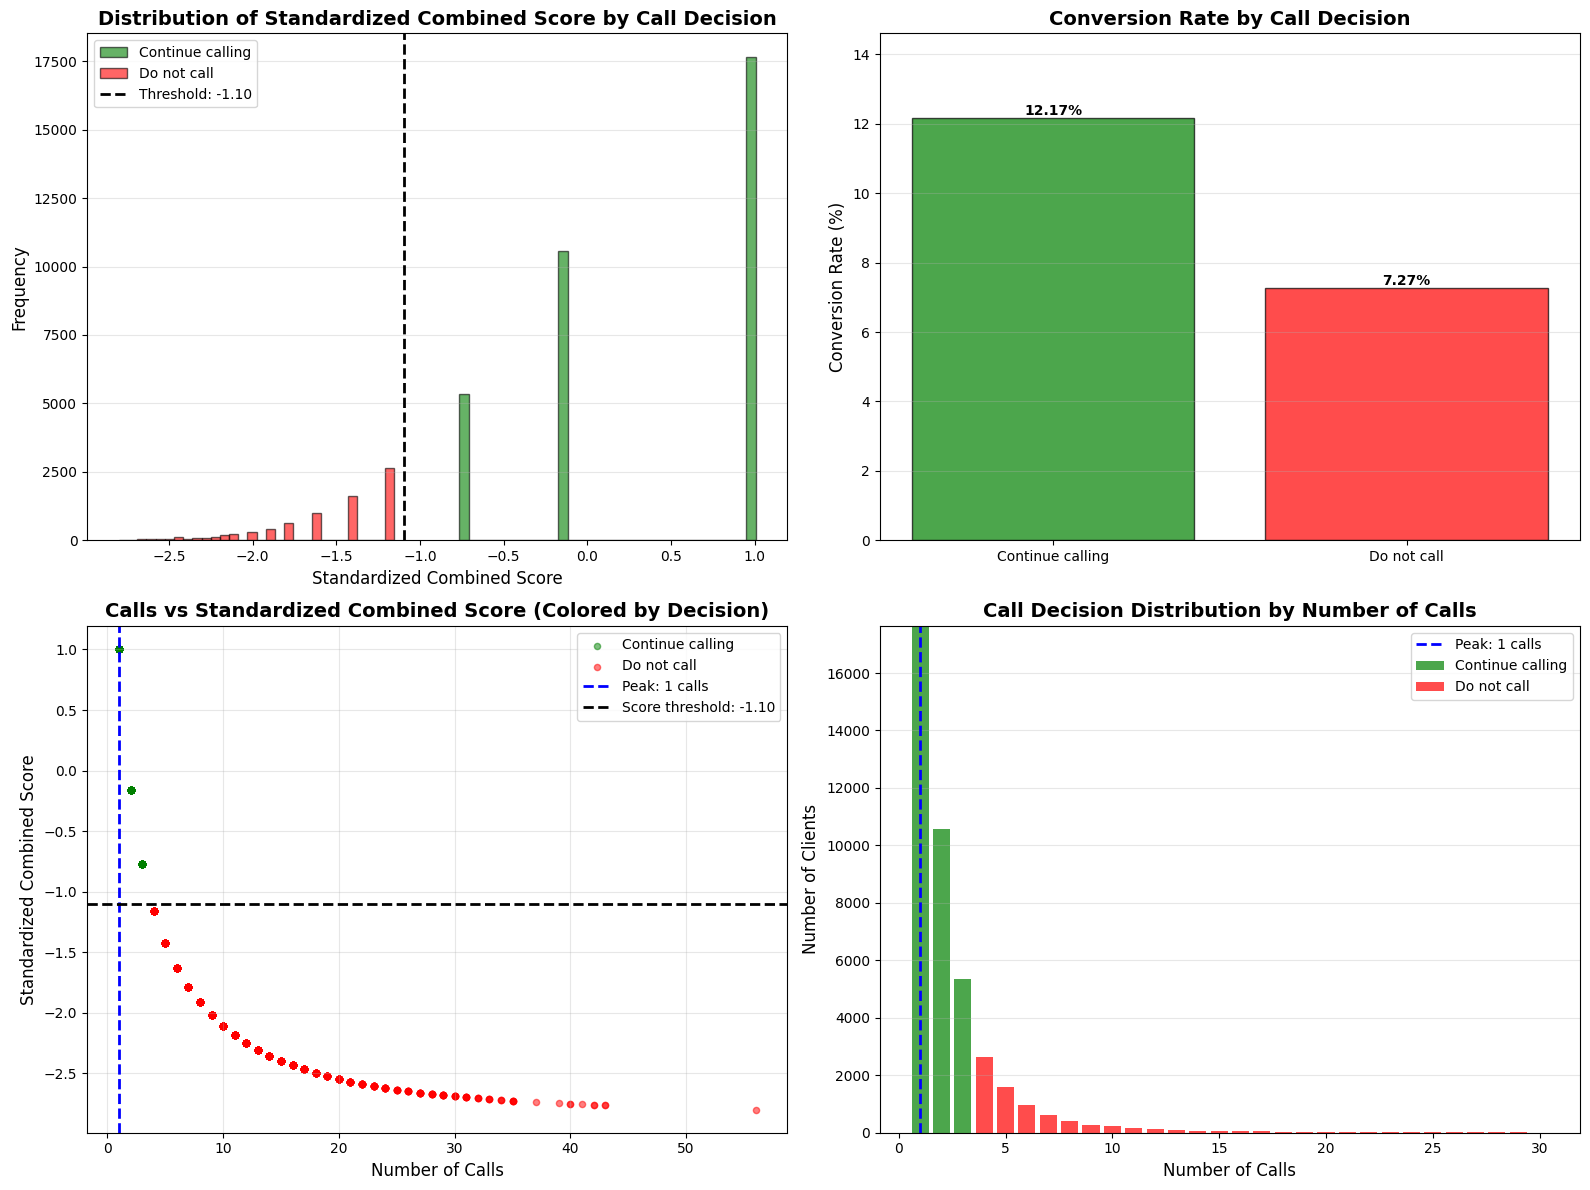


SUMMARY

Peak Conversion Rate: 13.04% at 1 calls
Inputted Calls: 22 calls
Conversion Rate at 22 calls: 0.00%

Difference: 100.0% reduction from peak

Recommendation: Calling is significantly less effective. Stop calling.


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path

# ============================================================================
# LOAD DATA AND SPLIT USING HOLDOUT METHOD (80/20 RANDOM SPLIT)
# ============================================================================
# Load the dataset
data_path = Path("Data/bank-additional-full.csv")
df = pd.read_csv(data_path, sep=';')

# Perform random 80/20 split using holdout method
train_df, eval_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,  # For reproducibility
    shuffle=True  # Random sampling
)

print(f"Data loaded: {len(df):,} total records")
print(f"Training set (80%): {len(train_df):,} records")
print(f"Test set (20%): {len(eval_df):,} records")

# ============================================================================
# STEP 1: FIND PEAK CALLING FREQUENCY
# ============================================================================
# Combine train and eval to analyze full dataset for peak finding
full_df = pd.concat([train_df, eval_df], ignore_index=True)

# Calculate actual conversion rate by number of calls
conversion_by_calls = full_df.groupby('campaign').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()]
}).reset_index()
conversion_by_calls.columns = ['calls', 'total_clients', 'yes_count', 'conversion_rate']

# Filter to calls with sufficient samples (at least 10 clients)
conversion_by_calls_filtered = conversion_by_calls[conversion_by_calls['total_clients'] >= 10].copy()

if len(conversion_by_calls_filtered) > 1:
    # Find peak conversion rate
    peak_idx = conversion_by_calls_filtered['conversion_rate'].idxmax()
    peak_calls = int(conversion_by_calls_filtered.loc[peak_idx, 'calls'])
    peak_rate = conversion_by_calls_filtered.loc[peak_idx, 'conversion_rate']

    # Find where conversion rate drops below 1% (stopping point)
    very_low = conversion_by_calls_filtered[conversion_by_calls_filtered['conversion_rate'] < 0.01]
    if len(very_low) > 0:
        stop_calls = int(very_low.iloc[0]['calls'])
    else:
        stop_calls = min(peak_calls * 2, int(conversion_by_calls_filtered['calls'].max()))
else:
    peak_calls = int(full_df['campaign'].median())
    stop_calls = int(full_df['campaign'].quantile(0.95))
    peak_rate = 0.0

# ============================================================================
# STEP 2: TRAIN MODEL AND CALCULATE SUBSCRIPTION LIKELIHOOD
# ============================================================================
# Prepare features/target
target_map = {'yes': 1, 'no': 0}
y_train = train_df['y'].map(target_map)
y_eval = eval_df['y'].map(target_map)
X_train = train_df[['campaign']]
X_eval = eval_df[['campaign']]

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate model on test set
y_pred = model.predict(X_eval)
y_pred_proba = model.predict_proba(X_eval)[:, 1]

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

train_accuracy = model.score(X_train, y_train)
test_accuracy = accuracy_score(y_eval, y_pred)
test_precision = precision_score(y_eval, y_pred, zero_division=0)
test_recall = recall_score(y_eval, y_pred, zero_division=0)
test_f1 = f1_score(y_eval, y_pred, zero_division=0)
test_auc = roc_auc_score(y_eval, y_pred_proba) if len(np.unique(y_eval)) > 1 else 0.0

print(f"\nModel Performance:")
print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Precision: {test_precision:.4f}")
print(f"  Test Recall: {test_recall:.4f}")
print(f"  Test F1-Score: {test_f1:.4f}")
print(f"  Test AUC-ROC: {test_auc:.4f}")

# Predict probabilities for all data
full_df = full_df.copy()
full_probs = model.predict_proba(full_df[['campaign']])[:, 1]
full_df['subscription_likelihood'] = full_probs

# Predict for train and eval separately
train_probs = model.predict_proba(X_train)[:, 1]
eval_probs = model.predict_proba(X_eval)[:, 1]

train_df_classified = train_df.copy()
eval_df_classified = eval_df.copy()
train_df_classified['subscription_likelihood'] = train_probs
eval_df_classified['subscription_likelihood'] = eval_probs

# ============================================================================
# STEP 3: STANDARDIZE SUBSCRIPTION LIKELIHOOD
# ============================================================================
# Create an inverted call score where 1 call = highest, more calls = lower
max_calls = full_df['campaign'].max()
full_df['inverted_call_score'] = 1.0 / (full_df['campaign'] + 1)
full_df['inverted_call_score'] = full_df['inverted_call_score'] / full_df['inverted_call_score'].max()

train_df_classified['inverted_call_score'] = 1.0 / (train_df_classified['campaign'] + 1)
train_df_classified['inverted_call_score'] = train_df_classified['inverted_call_score'] / train_df_classified['inverted_call_score'].max()

eval_df_classified['inverted_call_score'] = 1.0 / (eval_df_classified['campaign'] + 1)
eval_df_classified['inverted_call_score'] = eval_df_classified['inverted_call_score'] / eval_df_classified['inverted_call_score'].max()

# Create combined score: 40% call score, 60% subscription likelihood
full_df['combined_score'] = 0.4 * full_df['inverted_call_score'] + 0.6 * full_df['subscription_likelihood']
train_df_classified['combined_score'] = 0.4 * train_df_classified['inverted_call_score'] + 0.6 * train_df_classified['subscription_likelihood']
eval_df_classified['combined_score'] = 0.4 * eval_df_classified['inverted_call_score'] + 0.6 * eval_df_classified['subscription_likelihood']

# Standardize the combined score
scaler = StandardScaler()
full_df['standardized_score'] = scaler.fit_transform(full_df[['combined_score']])
train_df_classified['standardized_score'] = scaler.transform(train_df_classified[['combined_score']])
eval_df_classified['standardized_score'] = scaler.transform(eval_df_classified[['combined_score']])

# Keep standardized likelihood for reference
likelihood_scaler = StandardScaler()
full_df['likelihood_standardized'] = likelihood_scaler.fit_transform(full_df[['subscription_likelihood']])
train_df_classified['likelihood_standardized'] = likelihood_scaler.transform(train_df_classified[['subscription_likelihood']])
eval_df_classified['likelihood_standardized'] = likelihood_scaler.transform(eval_df_classified[['subscription_likelihood']])

# ============================================================================
# STEP 4: DETERMINE CLASSIFICATION THRESHOLD
# ============================================================================
def find_optimal_threshold_std(y_true, y_std_scores):
    """Find optimal threshold using Youden's J statistic on standardized scores."""
    thresholds = np.arange(y_std_scores.min(), y_std_scores.max(), 0.1)
    best_threshold = 0.0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_std_scores >= threshold).astype(int)
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))

        if (tp + fn) > 0 and (tn + fp) > 0:
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            youden_j = sensitivity + (0.93 * specificity)

            if youden_j > best_score:
                best_score = youden_j
                best_threshold = threshold

    return best_threshold

# Use actual conversion (yes/no) as the target for threshold optimization
y_full = (full_df['y'] == 'yes').astype(int)
optimal_std_threshold = find_optimal_threshold_std(y_full, full_df['standardized_score'])

# Find conversion rates by call count
conversion_by_calls_dict = dict(zip(conversion_by_calls['calls'], conversion_by_calls['conversion_rate']))
min_conversion_threshold = 0.01  # 1% minimum conversion rate to continue

# ============================================================================
# STEP 5: CLASSIFY CLIENTS INTO "CONTINUE CALLING" OR "DO NOT CALL"
# ============================================================================

def classify_client(calls, likelihood, standardized_score, inverted_call_score):
    """
    Classify client as "Continue calling" or "Do not call"

    Uses standardized combined score that accounts for:
    - Inverted call score (fewer calls = higher score)
    - Subscription likelihood (higher probability = higher score)

    Continue calling if standardized combined score > threshold
    OR if calls are low and conversion rate is still reasonable
    """
    # Primary criterion: standardized combined score
    score_above_threshold = standardized_score > optimal_std_threshold

    # Secondary criterion: if calls are low and conversion rate is still reasonable
    calls_low = calls <= peak_calls
    conversion_rate = conversion_by_calls_dict.get(calls, 0.0)
    conversion_still_good = conversion_rate > min_conversion_threshold

    # Continue if primary criterion OR (low calls AND good conversion)
    continue_calling = score_above_threshold or (calls_low and conversion_still_good)

    return "Continue calling" if continue_calling else "Do not call"

# Classify all clients
full_df['call_decision'] = full_df.apply(
    lambda row: classify_client(row['campaign'], row['subscription_likelihood'],
                                row['standardized_score'], row['inverted_call_score']),
    axis=1
)

train_df_classified['call_decision'] = train_df_classified.apply(
    lambda row: classify_client(row['campaign'], row['subscription_likelihood'],
                               row['standardized_score'], row['inverted_call_score']),
    axis=1
)

eval_df_classified['call_decision'] = eval_df_classified.apply(
    lambda row: classify_client(row['campaign'], row['subscription_likelihood'],
                               row['standardized_score'], row['inverted_call_score']),
    axis=1
)

# Analyze conversion rates by decision
decision_analysis = full_df.groupby('call_decision').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()],
    'subscription_likelihood': 'mean',
    'standardized_score': 'mean',
    'inverted_call_score': 'mean',
    'campaign': 'mean'
}).reset_index()
decision_analysis.columns = ['decision', 'total', 'yes_count', 'conversion_rate', 'avg_likelihood', 'avg_std_score', 'avg_inv_call_score', 'avg_calls']

# ============================================================================
# STEP 6: BUILD PREDICTIVE MODEL FOR CALL DECISION
# ============================================================================
# Create binary target for call decision (1 = Continue, 0 = Stop)
train_df_classified['should_call'] = (train_df_classified['call_decision'] == 'Continue calling').astype(int)
eval_df_classified['should_call'] = (eval_df_classified['call_decision'] == 'Continue calling').astype(int)

# Features: campaign, subscription_likelihood, standardized_score, inverted_call_score
X_train_decision = train_df_classified[['campaign', 'subscription_likelihood', 'standardized_score', 'inverted_call_score']]
X_eval_decision = eval_df_classified[['campaign', 'subscription_likelihood', 'standardized_score', 'inverted_call_score']]
y_train_decision = train_df_classified['should_call']
y_eval_decision = eval_df_classified['should_call']

# Train decision model
decision_model = LogisticRegression()
decision_model.fit(X_train_decision, y_train_decision)

# ============================================================================
# VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribution of standardized combined score by decision
ax1 = axes[0, 0]
continue_std = full_df[full_df['call_decision'] == 'Continue calling']['standardized_score']
stop_std = full_df[full_df['call_decision'] == 'Do not call']['standardized_score']

ax1.hist(continue_std, bins=30, alpha=0.6, label='Continue calling', color='green', edgecolor='black')
ax1.hist(stop_std, bins=30, alpha=0.6, label='Do not call', color='red', edgecolor='black')
ax1.axvline(x=optimal_std_threshold, color='black', linestyle='--', linewidth=2,
           label=f'Threshold: {optimal_std_threshold:.2f}')
ax1.set_xlabel('Standardized Combined Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Standardized Combined Score by Call Decision', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Conversion rate by call decision
ax2 = axes[0, 1]
continue_rate = decision_analysis[decision_analysis['decision'] == 'Continue calling']['conversion_rate'].values[0] * 100
stop_rate = decision_analysis[decision_analysis['decision'] == 'Do not call']['conversion_rate'].values[0] * 100

categories = ['Continue calling', 'Do not call']
rates = [continue_rate, stop_rate]
colors = ['green', 'red']
bars = ax2.bar(categories, rates, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Conversion Rate (%)', fontsize=12)
ax2.set_title('Conversion Rate by Call Decision', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(rates) * 1.2)
ax2.grid(True, alpha=0.3, axis='y')

for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Number of calls vs standardized combined score (colored by decision)
ax3 = axes[1, 0]
continue_df = full_df[full_df['call_decision'] == 'Continue calling']
stop_df = full_df[full_df['call_decision'] == 'Do not call']

ax3.scatter(continue_df['campaign'], continue_df['standardized_score'],
           alpha=0.5, s=20, label='Continue calling', color='green')
ax3.scatter(stop_df['campaign'], stop_df['standardized_score'],
           alpha=0.5, s=20, label='Do not call', color='red')
ax3.axvline(x=peak_calls, color='blue', linestyle='--', linewidth=2,
           label=f'Peak: {peak_calls} calls')
ax3.axhline(y=optimal_std_threshold, color='black', linestyle='--', linewidth=2,
           label=f'Score threshold: {optimal_std_threshold:.2f}')
ax3.set_xlabel('Number of Calls', fontsize=12)
ax3.set_ylabel('Standardized Combined Score', fontsize=12)
ax3.set_title('Calls vs Standardized Combined Score (Colored by Decision)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Decision breakdown by number of calls
ax4 = axes[1, 1]
call_decision_counts = full_df.groupby(['campaign', 'call_decision']).size().unstack(fill_value=0)
call_range = call_decision_counts.index[:min(30, len(call_decision_counts))]

if 'Continue calling' in call_decision_counts.columns:
    ax4.bar(call_range, call_decision_counts.loc[call_range, 'Continue calling'],
           label='Continue calling', color='green', alpha=0.7)
if 'Do not call' in call_decision_counts.columns:
    ax4.bar(call_range, call_decision_counts.loc[call_range, 'Do not call'],
           bottom=call_decision_counts.loc[call_range, 'Continue calling'] if 'Continue calling' in call_decision_counts.columns else 0,
           label='Do not call', color='red', alpha=0.7)

ax4.axvline(x=peak_calls, color='blue', linestyle='--', linewidth=2,
           label=f'Peak: {peak_calls} calls')
ax4.set_xlabel('Number of Calls', fontsize=12)
ax4.set_ylabel('Number of Clients', fontsize=12)
ax4.set_title('Call Decision Distribution by Number of Calls', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# INTERACTIVE PREDICTION AND SUMMARY
# ============================================================================
call_number = int(input("Enter the number of calls for a client: "))

# Get conversion rates
peak_conversion_rate = peak_rate
input_conversion_rate = conversion_by_calls_dict.get(call_number, 0.0)

# Calculate the difference
if peak_conversion_rate > 0:
    reduction = ((peak_conversion_rate - input_conversion_rate) / peak_conversion_rate) * 100
else:
    reduction = 0.0

# Determine recommendation
if call_number == peak_calls:
    recommendation = "Optimal - This is the peak conversion rate. Continue calling."
else:  # call_number > peak_calls
    if reduction <= 5:
        recommendation = "The success rate is close to optimal. Continue calling."
    elif reduction <= 15:
        recommendation = "The success rate remains high. Continue calling."
    elif reduction <= 29:
        recommendation = "Calling is still doable but not recommended."
    elif reduction <= 36:
        recommendation = "Calling is less effective. Consider stopping soon."
    else:
        recommendation = "Calling is significantly less effective. Stop calling."

# Print summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nPeak Conversion Rate: {peak_conversion_rate*100:.2f}% at {peak_calls} calls")
print(f"Inputted Calls: {call_number} calls")
print(f"Conversion Rate at {call_number} calls: {input_conversion_rate*100:.2f}%")
print(f"\nDifference: {reduction:.1f}% reduction from peak")
print(f"\nRecommendation: {recommendation}")
print("="*70)
